In [3]:
import pandas as pd
import numpy as np
import pywt
from scipy.signal import savgol_filter
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import re
from sklearn.metrics import confusion_matrix
from collections import Counter

In [4]:
annotation_classes_map = {
    'N': 'Normal beat',
    'L': 'Left bundle branch block beat',
    'R': 'Right bundle branch block beat',
    'V': 'Premature ventricular contraction',
    '/': 'Paced beat',
    'f': 'Fusion of paced and normal beat',
}

In [5]:
# Function to remove baseline wander using DWT
def remove_baseline_wander(signal, wavelet="db4", level=8):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    coeffs[-1] = np.zeros_like(coeffs[-1])
    return pywt.waverec(coeffs, wavelet)

# Function to smooth signal using Savitzky-Golay filter
def smooth_signal(signal, window_length=11, polyorder=3):
    return savgol_filter(signal, window_length, polyorder)

# Function to segment the ECG signal around the R-peaks
def segment_ecg_signal(ecg_signal, annotations_df, r_peak_offset=100, segment_length=251):
    segments = []
    for _, row in annotations_df.iterrows():
        r_peak = row['Sample #']
        start = max(r_peak - r_peak_offset, 0)  # ensure start is not negative
        end = min(start + segment_length, len(ecg_signal))  # ensure end does not go past the signal length
        segment = ecg_signal[start:end]
        if len(segment) == segment_length:  # only append if the segment is the correct length
            segments.append(segment)
    return segments

# Function to extract features using DWT
def extract_dwt_features(segments, wavelet='db2', level=4):
    features = []
    for segment in segments:
        coeffs = pywt.wavedec(segment, wavelet, level=level)
        # Only use the approximation coefficients at the given level
        features.append(coeffs[0])
    return features

def parse_annotations(annotations):
    annotation_pattern = re.compile(r'\s*(\d+:\d+\.\d+)\s+(\d+)\s+(\S+)\s+(\d+)\s+(\d+)\s+(\d+)\s*(\(.*\))?')
    parsed_annotations = []
    for line in annotations:
        match = annotation_pattern.match(line)
        if match:
            time, sample_number, annotation_type, sub, chan, num, aux = match.groups()
            annotation_type_mapped = annotation_type if annotation_type in annotation_classes_map else 'Other' 
            parsed_annotations.append((time, int(sample_number), annotation_type_mapped, int(sub), int(chan), int(num), aux))
    return pd.DataFrame(parsed_annotations, columns=['Time', 'Sample #', 'Type', 'Sub', 'Chan', 'Num', 'Aux'])

In [6]:
train_patient_ids = ['100', '104', '108', 
                     '117', '201', '207', 
                     '212', '217', '222', 
                     '231', '101', '114', 
                     '123', '208', '213', 
                     '219', '223', '232', 
                     '102', '106', '119', 
                     '124', '203', '209', 
                     '214', '228', '233', 
                     '103', '107', '112', 
                     '116', '121', '200', 
                     '205', '210', '215', 
                     '221', '230', '234']

# Initialize empty lists to hold the aggregated features and labels
all_features = []
all_labels = []

beat_type_counter = Counter()

for patient_id in train_patient_ids:
    # Load the ECG data and annotations for each patient
    with open(f'./datasets/{patient_id}annotations.txt', 'r') as file:
        annotations = file.readlines()
        
    ecg_data = pd.read_csv(f'./datasets/{patient_id}.csv')
    annotations_df = parse_annotations(annotations)
    
    # Sampling rate and duration for 5 minutes
    sampling_rate = 360  # samples per second for MIT-BIH
    duration = 10 * 60  
    num_samples = duration * sampling_rate

    ecg_data.columns = ecg_data.columns.str.strip("'")

    start_sample = 0  
    ecg_portion = ecg_data.iloc[start_sample:start_sample + num_samples].copy()
    ecg_portion['ECG_baseline_removed'] = remove_baseline_wander(ecg_portion['MLII'])
    ecg_portion['ECG_smoothed'] = smooth_signal(ecg_portion['ECG_baseline_removed'])

    # Filter annotations to only include those within the 5-minute window
    annotations_portion = annotations_df[(annotations_df['Sample #'] >= start_sample) & 
                                        (annotations_df['Sample #'] < start_sample + num_samples)]
    ecg_segments = segment_ecg_signal(ecg_portion['ECG_smoothed'], annotations_portion)
    ecg_features = extract_dwt_features(ecg_segments)

    feature_matrix_patient = np.array(ecg_features)
    labels_patient = annotations_portion['Type'].values[:len(ecg_features)]  # Ensuring labels align with the segments

    # Append the features and labels to the aggregate lists
    all_features.append(feature_matrix_patient)
    all_labels.append(labels_patient)
    beat_type_counter.update(labels_patient)

# Combine all features and labels into single arrays
all_features = np.vstack(all_features)
all_labels = np.concatenate(all_labels)

print(beat_type_counter)

Counter({'N': 21084, '/': 2248, 'V': 2223, 'Other': 2090, 'R': 1775, 'L': 1138, 'f': 354})


In [7]:
desired_counts = {
    'N': 850,
    'L': 500,
    'R': 850,
    'f': 150,
    'V': 300,
    '/': 550
}

balanced_features = []
balanced_labels = []

# For each beat type, balance according to the desired count
for beat_type, count in desired_counts.items():
    indices = np.where(all_labels == beat_type)[0]

    if beat_type_counter[beat_type] > count:
        chosen_indices = np.random.choice(indices, count, replace=False)
    else:
        chosen_indices = np.random.choice(indices, count, replace=True)

    # Append the balanced data
    balanced_features.append(all_features[chosen_indices])
    balanced_labels.append(all_labels[chosen_indices])

# Combine all balanced data into single arrays
balanced_features = np.vstack(balanced_features)
balanced_labels = np.concatenate(balanced_labels)


# Confirm the balancing
print(Counter(balanced_labels))


Counter({'N': 850, 'R': 850, '/': 550, 'L': 500, 'V': 300, 'f': 150})


In [8]:
test_patient_ids = ['105', '109', '111', '113', '115', '118', '122', '202', '220']

for test_patient_id in test_patient_ids:
    with open(f'./datasets/{test_patient_id}annotations.txt', 'r') as file:
        annotations = file.readlines()
    
    ecg_test_data = pd.read_csv(f'./datasets/{test_patient_id}.csv')
    annotations_test_df = parse_annotations(annotations)
    ecg_test_data.columns = ecg_test_data.columns.str.strip("'")

    # Sampling rate and duration for 5 minutes
    sampling_rate = 360  # samples per second for MIT-BIH
    duration = 5 * 60  # 5 minutes in seconds
    num_samples = duration * sampling_rate

    start_sample = 0  
    ecg_test_portion = ecg_test_data.iloc[start_sample:start_sample + num_samples].copy()
    ecg_test_portion['ECG_baseline_removed'] = remove_baseline_wander(ecg_test_portion['MLII'])
    ecg_test_portion['ECG_smoothed'] = smooth_signal(ecg_test_portion['ECG_baseline_removed'])

    # Filter annotations to only include those within the 5-minute window
    annotations_test_portion = annotations_test_df[(annotations_test_df['Sample #'] >= start_sample) & 
                                        (annotations_test_df['Sample #'] < start_sample + num_samples)]

    ecg_test_segments = segment_ecg_signal(ecg_test_portion['ECG_smoothed'], annotations_test_portion)
    ecg_test_features = extract_dwt_features(ecg_test_segments)

    feature_matrix_test = np.array(ecg_test_features)
    labels_test_patient = annotations_test_portion['Type'].values[:len(ecg_test_features)]  # Ensuring labels align with the segments
    
    scaler = StandardScaler()
    
    
    X_train_scaled = scaler.fit_transform(all_features)
    X_test_scaled = scaler.transform(feature_matrix_test)

    svm_classifier = SVC(kernel='rbf', gamma='auto', class_weight='balanced')

    svm_classifier.fit(X_train_scaled, all_labels)

    # Prediction and evaluation
    y_pred = svm_classifier.predict(X_test_scaled)
    accuracy = accuracy_score(labels_test_patient, y_pred)
    print("---------------------------------------------------")
    print(f'Accuracy for patient {test_patient_id}: {accuracy}')

    classification_rep_test = classification_report(labels_test_patient, y_pred, labels=np.unique(labels_test_patient), 
                                                target_names=[annotation_classes_map.get(label, 'Other') for label in np.unique(labels_test_patient)], 
                                                zero_division=0)

    print(classification_rep_test)

---------------------------------------------------
Accuracy for patient 105: 0.9458823529411765
                                   precision    recall  f1-score   support

                      Normal beat       0.98      0.97      0.97       404
                            Other       0.56      1.00      0.72         9
Premature ventricular contraction       0.50      0.17      0.25        12

                        micro avg       0.95      0.95      0.95       425
                        macro avg       0.68      0.71      0.65       425
                     weighted avg       0.95      0.95      0.95       425

---------------------------------------------------
Accuracy for patient 109: 0.011547344110854504
                                   precision    recall  f1-score   support

    Left bundle branch block beat       0.00      0.00      0.00       424
                            Other       0.20      0.33      0.25         3
Premature ventricular contraction       0.02      

# Preprocessing Showcase

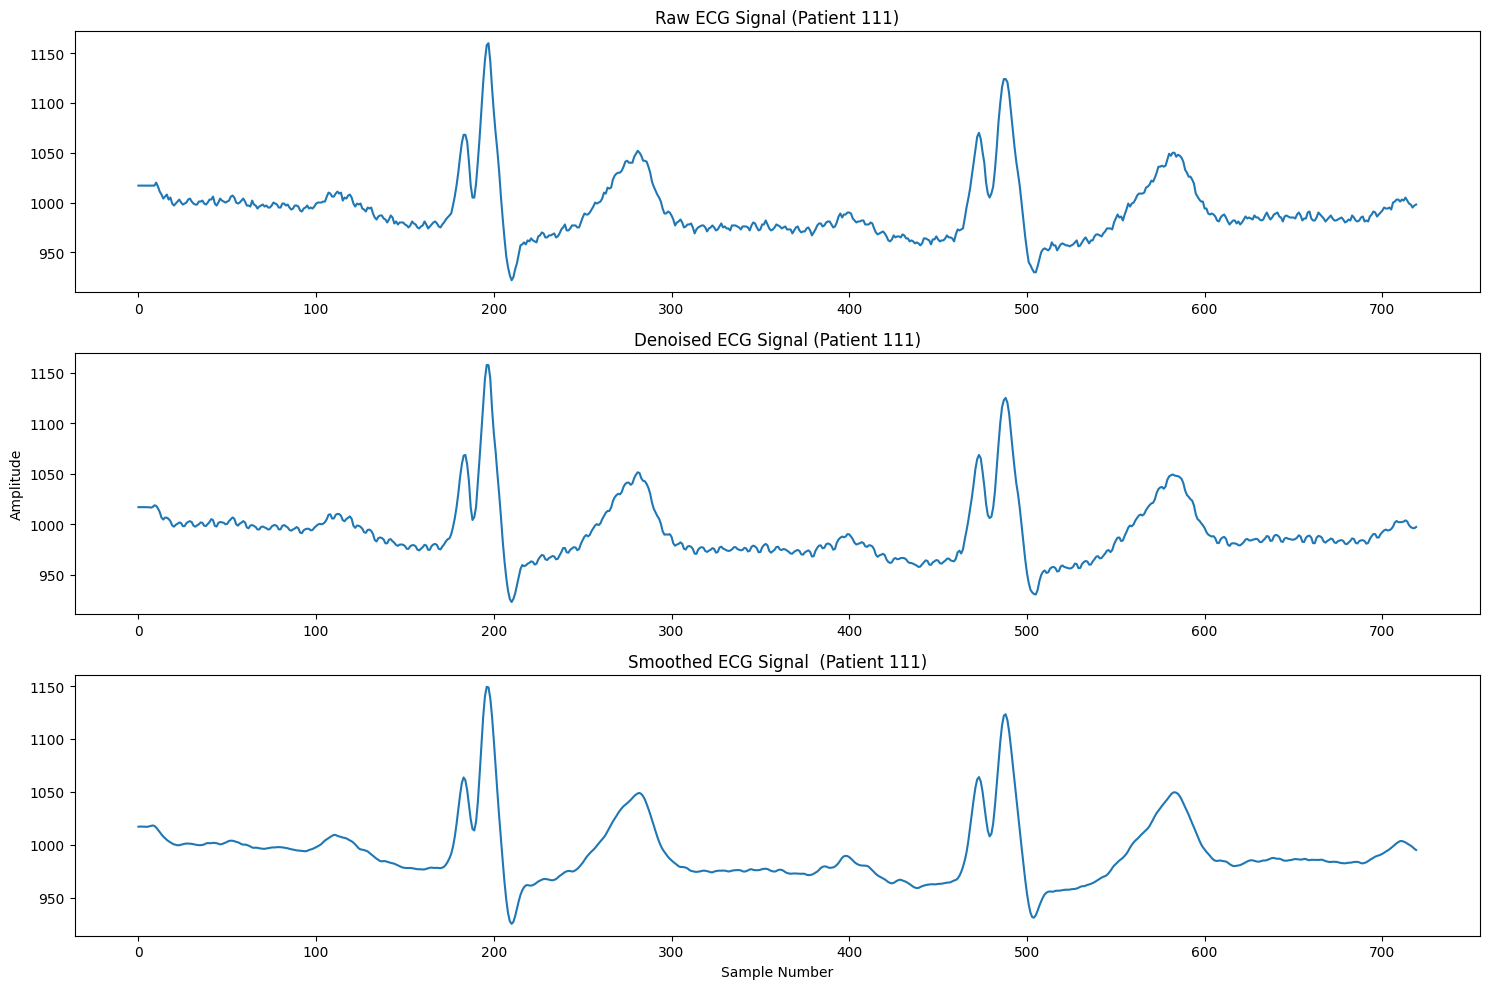

In [9]:
import matplotlib.pyplot as plt

# Selecting a sample signal
sample_signal = pd.read_csv('./datasets/111.csv')
sample_signal.columns = sample_signal.columns.str.strip("'")
sample_signal = sample_signal['MLII']

# Applying noise reduction
denoised_signal = remove_baseline_wander(sample_signal)
smoothed_signal = smooth_signal(denoised_signal)

# Define the range of interest for plotting 
start, end = 0, 2 * 360 

# Plotting
plt.figure(figsize=(15, 10))

# Raw Signal
plt.subplot(3, 1, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(sample_signal[start:end])
plt.title('Raw ECG Signal (Patient 111)')

# Denoised Signal
plt.subplot(3, 1, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(denoised_signal[start:end])
plt.title('Denoised ECG Signal (Patient 111)')
plt.ylabel('Amplitude')

# Smoothed Signal
plt.subplot(3, 1, 3)  # 3 rows, 1 column, 3rd subplot
plt.plot(smoothed_signal[start:end])
plt.title('Smoothed ECG Signal  (Patient 111)')
plt.xlabel('Sample Number')

plt.tight_layout()
plt.show()

# Single Case Example

In [10]:
# Load the data
with open('./datasets/111annotations.txt', 'r') as file:
    annotations = file.readlines()
ecg_data111 = pd.read_csv('./datasets/111.csv')
annotations_df111 = parse_annotations(annotations)

# Correct the column names by removing extra quotation marks
ecg_data111.columns = ecg_data111.columns.str.strip("'")

# Sampling rate and duration for 5 minutes
sampling_rate = 360  # samples per second for MIT-BIH
duration = 5 * 60  # 5 minutes in seconds
num_samples = duration * sampling_rate

# Extract a 5-minute portion of the ECG data
start_sample = 0  # You can adjust this as needed
ecg_portion111 = ecg_data.iloc[start_sample:start_sample + num_samples].copy()
ecg_portion111['ECG_baseline_removed'] = remove_baseline_wander(ecg_portion111['MLII'])
ecg_portion111['ECG_smoothed'] = smooth_signal(ecg_portion111['ECG_baseline_removed'])

# Filter annotations to only include those within the 5-minute window
annotations_portion111 = annotations_df111[(annotations_df111['Sample #'] >= start_sample) & 
                                     (annotations_df111['Sample #'] < start_sample + num_samples)]

# Segmentation and feature extraction on the 5-minute portion
ecg_segments111 = segment_ecg_signal(ecg_portion111['ECG_smoothed'], annotations_portion111)
ecg_features111 = extract_dwt_features(ecg_segments111)

# Feature matrix and labels for the 5-minute portion
feature_matrix111 = np.array(ecg_features111)
labels111 = annotations_portion111['Type'].values[:len(ecg_features111)]  # Ensuring labels align with the segments

print()

In [11]:
with open('datasets/109annotations.txt', 'r') as file:
    annotations_109 = file.readlines()
ecg_data_109 = pd.read_csv('datasets/109.csv')
annotations_df_109 = parse_annotations(annotations_109)

ecg_data_109.columns = ecg_data_109.columns.str.strip("'")

ecg_portion109 = ecg_data_109.iloc[start_sample:start_sample + num_samples].copy()
ecg_portion109['ECG_baseline_removed'] = remove_baseline_wander(ecg_portion109['MLII'])
ecg_portion109['ECG_smoothed'] = smooth_signal(ecg_portion109['ECG_baseline_removed'])

annotations_portion109 = annotations_df_109[(annotations_df_109['Sample #'] >= start_sample) & 
                                     (annotations_df_109['Sample #'] < start_sample + num_samples)]

# Segmentation and feature extraction on the 5-minute portion
ecg_segments109 = segment_ecg_signal(ecg_portion109['ECG_smoothed'], annotations_portion109)
ecg_features109 = extract_dwt_features(ecg_segments109)

# Feature matrix and labels for the 5-minute portion
feature_matrix109 = np.array(ecg_features109)
labels109 = annotations_portion109['Type'].values[:len(ecg_features109)]  # Ensuring labels align with the segments

print(pd.Series(labels109).value_counts())
print()

L        424
V          6
Other      3
Name: count, dtype: int64



In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(feature_matrix111)
X_test_scaled = scaler.transform(feature_matrix109)

# SVM training with patient 111's data
svm_classifier = SVC(kernel='rbf', gamma='scale')
svm_classifier.fit(X_train_scaled, labels111)

# Prediction and evaluation
y_pred = svm_classifier.predict(X_test_scaled)
accuracy = accuracy_score(labels109, y_pred)

# Generate the classification report for patient 109's data
classification_rep_109 = classification_report(labels109, y_pred, labels=np.unique(labels109), target_names=[annotation_classes_map.get(label, 'Other') for label in np.unique(labels109)], zero_division=0)

print(f'Accuracy for patient 109: {accuracy}')
print(classification_rep_109)

cm = confusion_matrix(labels109, y_pred, labels=np.unique(labels109))
print()

# Calculate additional metrics from the confusion matrix if needed
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP / (TP + FN)
# Precision or positive predictive value
PPV = TP / (TP + FP)
# Overall accuracy for each class
ACC = (TP + TN) / (TP + FP + FN + TN)

# Print additional metrics
print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"True Negatives (TN): {TN}")
print(f"Sensitivity (TPR): {TPR}")
print(f"Precision (PPV): {PPV}")
print(f"Accuracy (ACC): {ACC}\n\n\n")

Accuracy for patient 109: 0.9792147806004619
                                   precision    recall  f1-score   support

    Left bundle branch block beat       0.98      1.00      0.99       424
                            Other       0.00      0.00      0.00         3
Premature ventricular contraction       0.00      0.00      0.00         6

                         accuracy                           0.98       433
                        macro avg       0.33      0.33      0.33       433
                     weighted avg       0.96      0.98      0.97       433


True Positives (TP): [424   0   0]
False Positives (FP): [9 0 0]
False Negatives (FN): [0 3 6]
True Negatives (TN): [  0 430 427]
Sensitivity (TPR): [1. 0. 0.]
Precision (PPV): [0.97921478        nan        nan]
Accuracy (ACC): [0.97921478 0.99307159 0.98614319]





/var/folders/g4/jgjlsdxn2hd3fg2yfrd791gh0000gn/T/ipykernel_3657/2035090956.py:31: RuntimeWarning: invalid value encountered in divide
  PPV = TP / (TP + FP)


# Stochastic Analysis

In [13]:
"""
    1. Load and show database
    2. plot histogram of the time between peaks
    3. autocorrelation function of all patients
    4. spectral density of all patients
"""

'\n    1. Load and show database\n    2. plot histogram of the time between peaks\n    3. autocorrelation function of all patients\n    4. spectral density of all patients\n'

## Time Difference Histograms

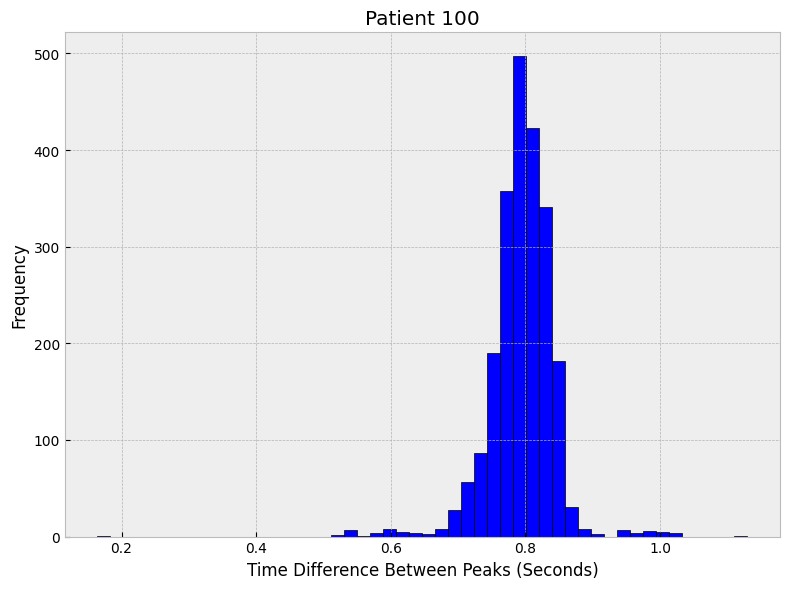

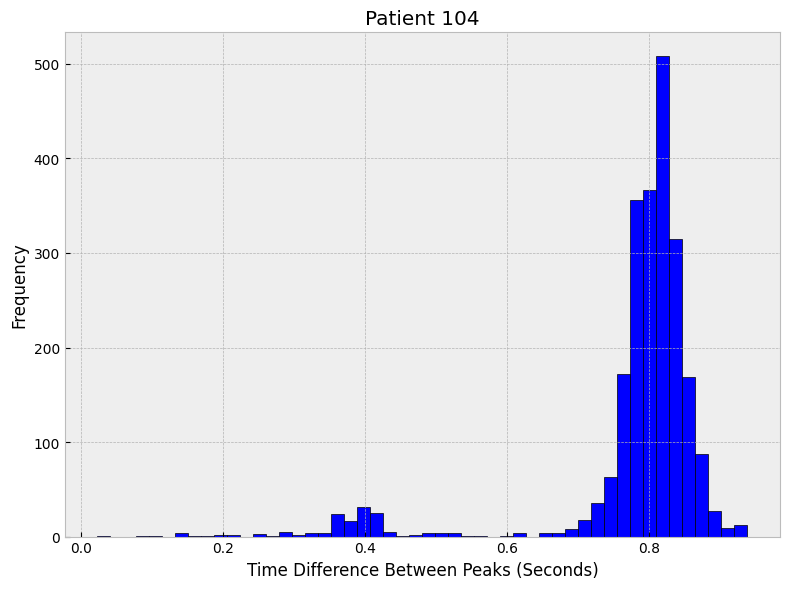

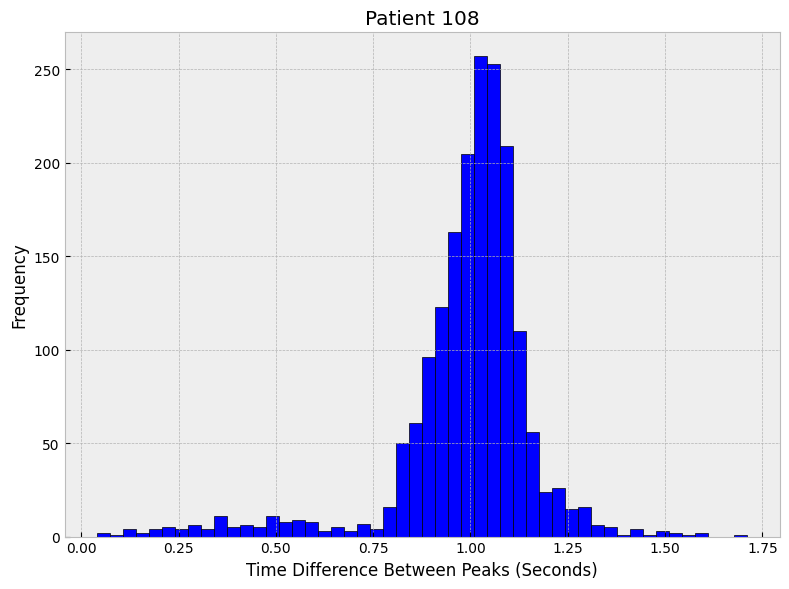

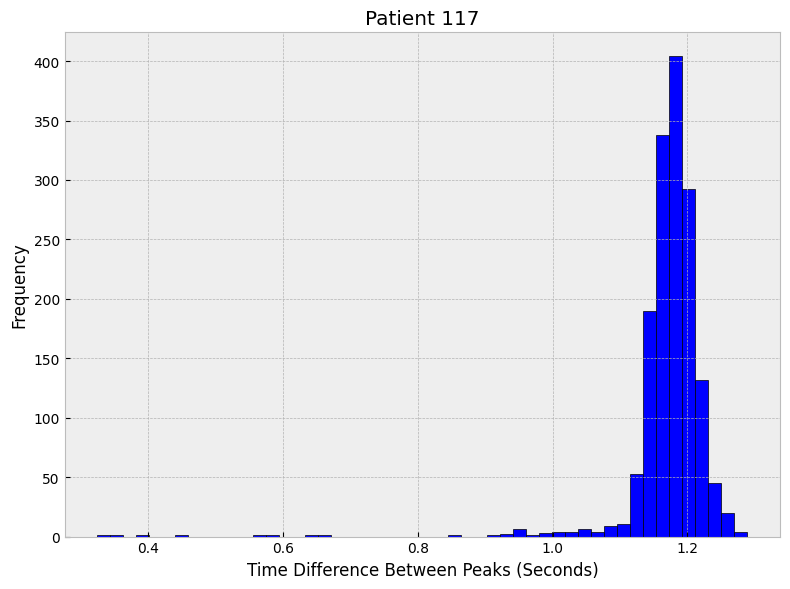

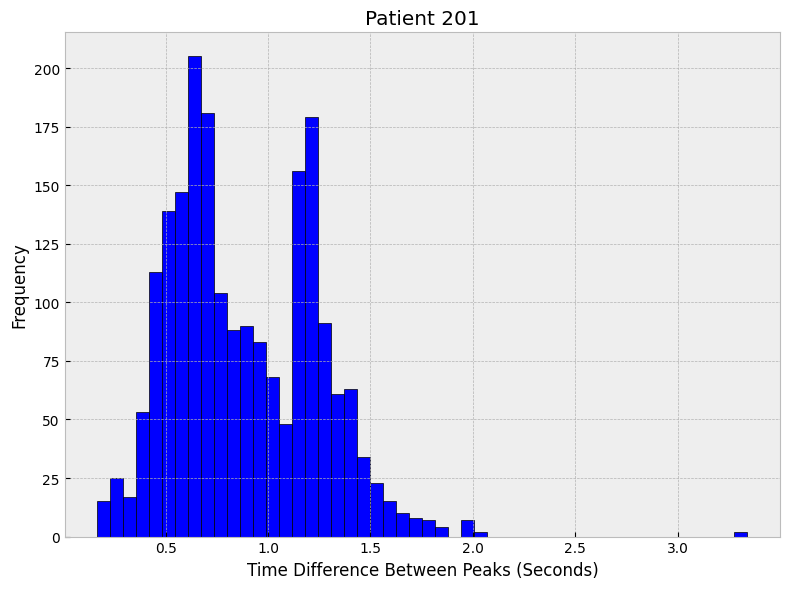

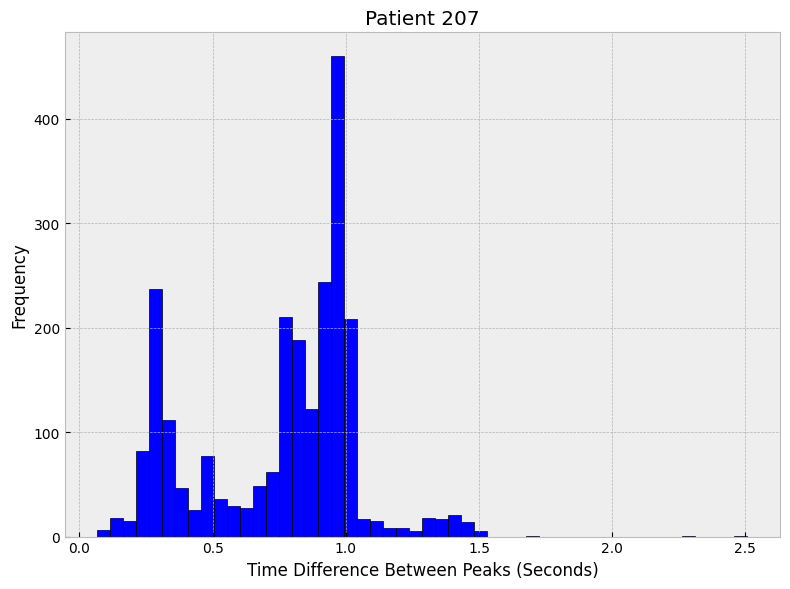

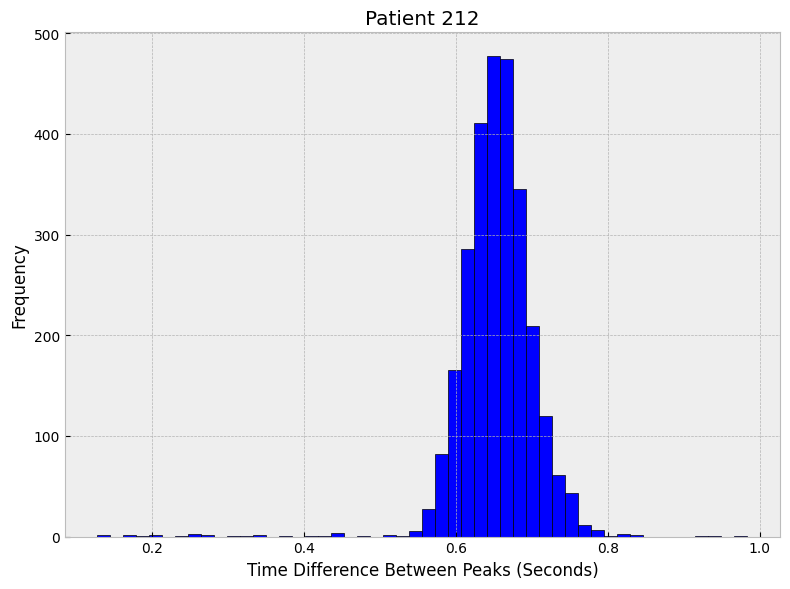

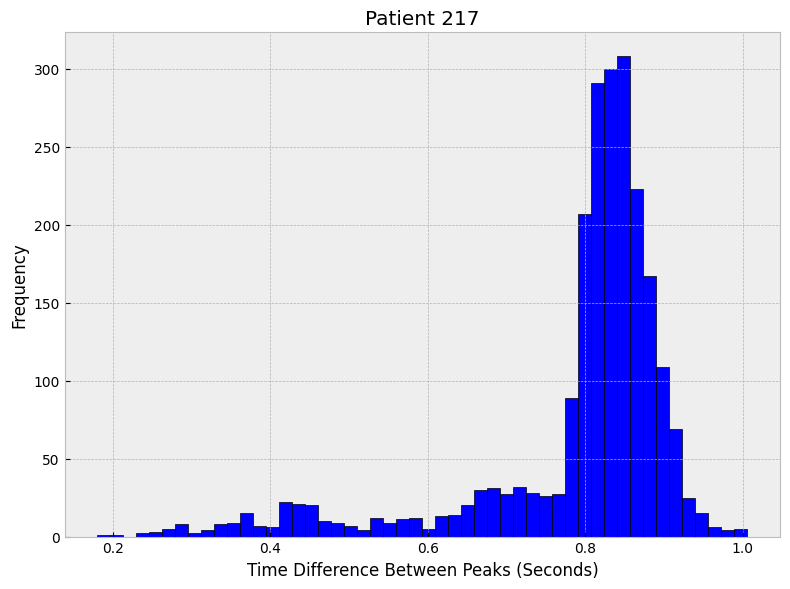

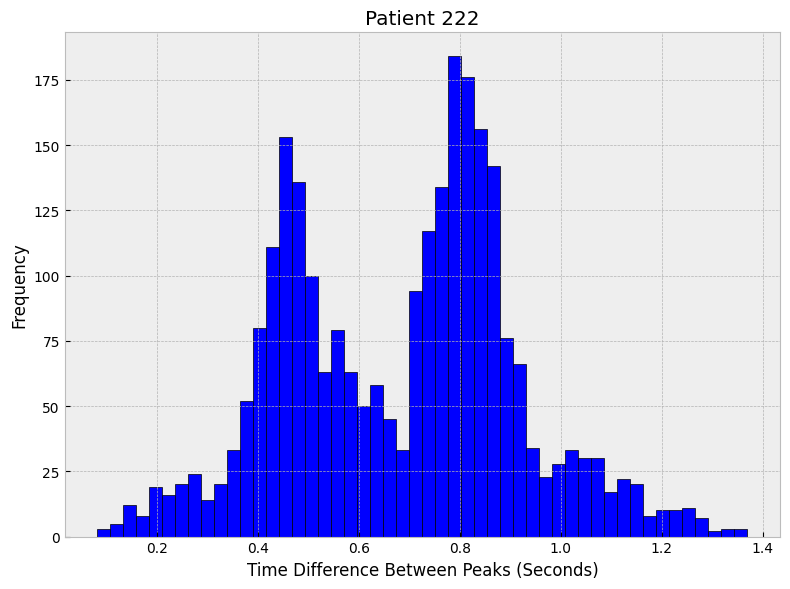

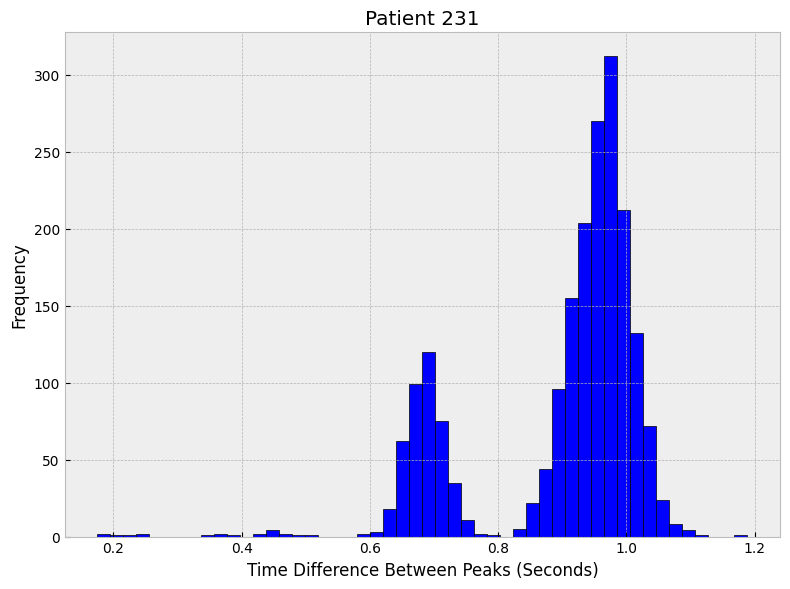

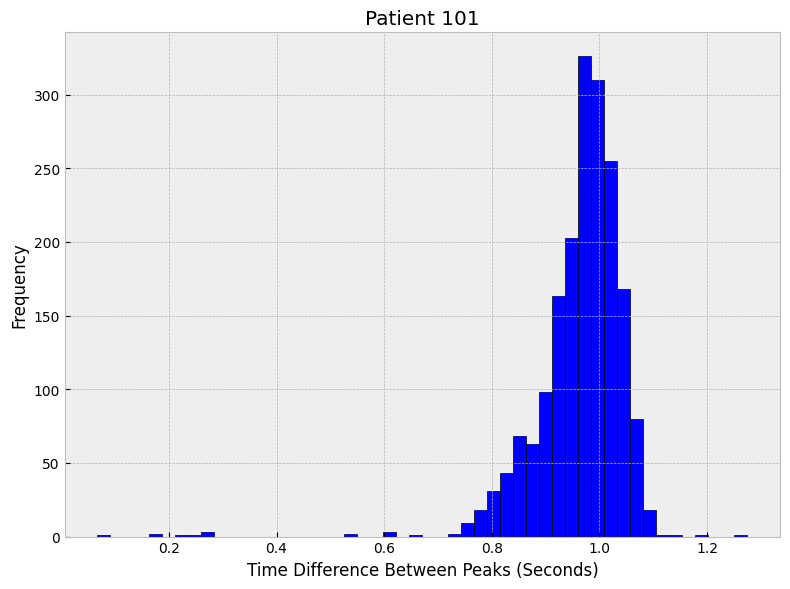

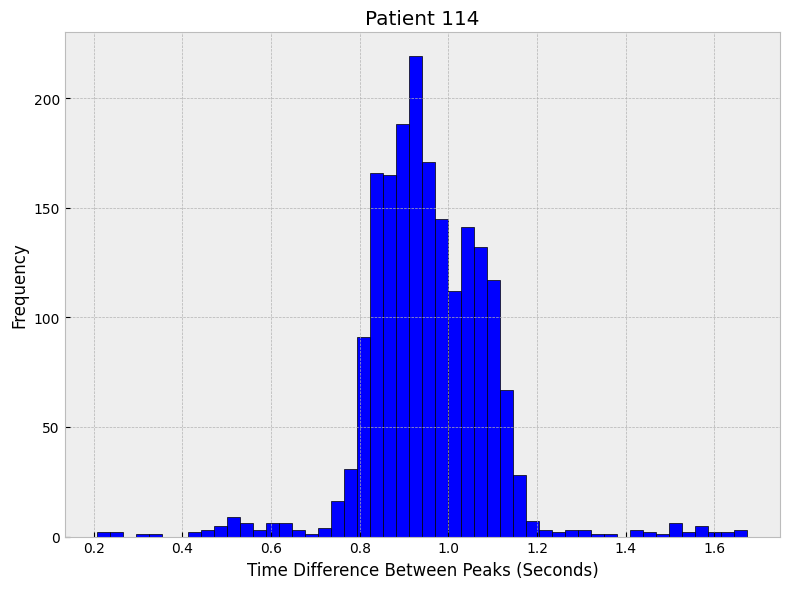

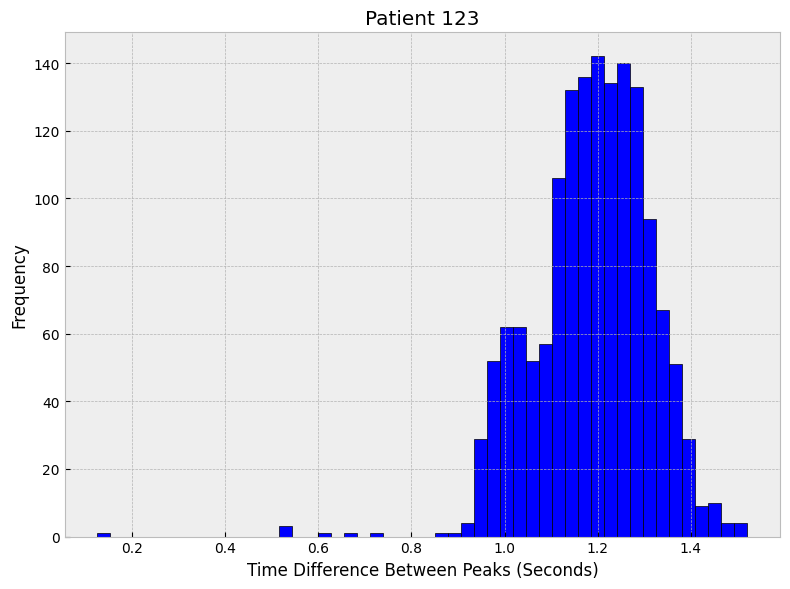

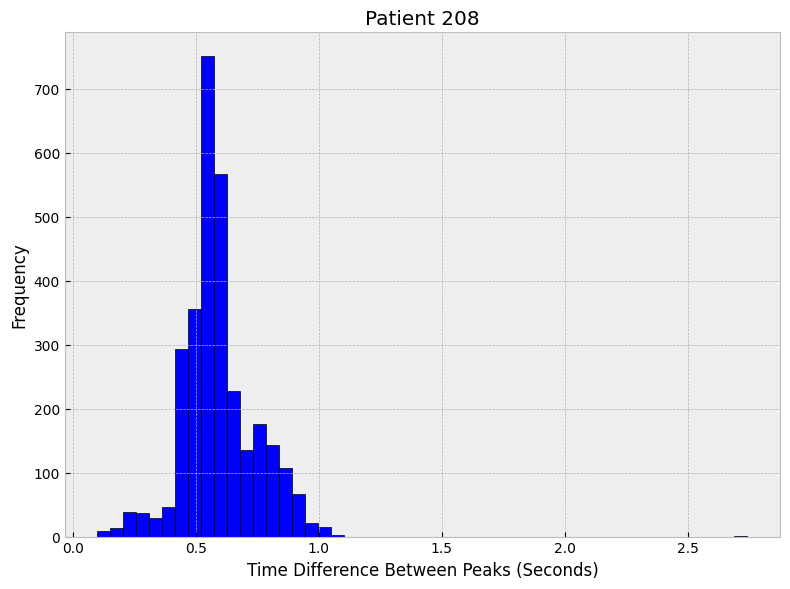

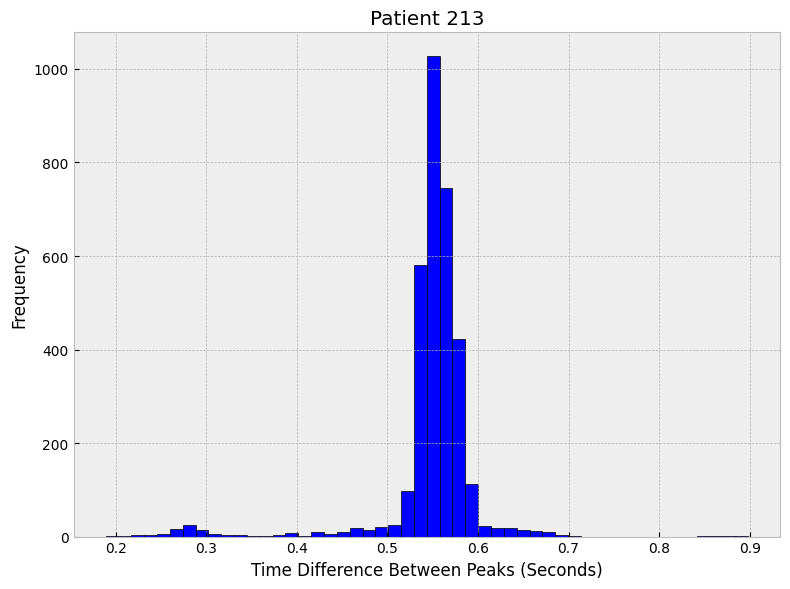

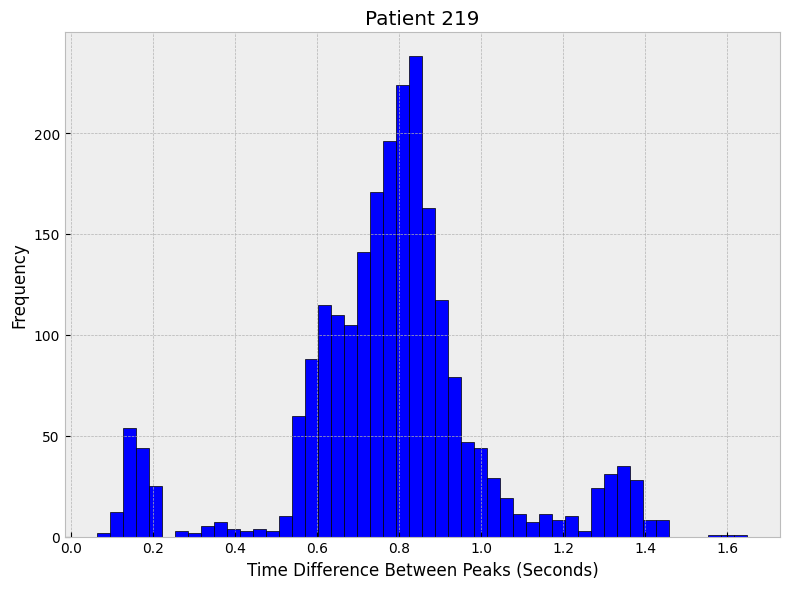

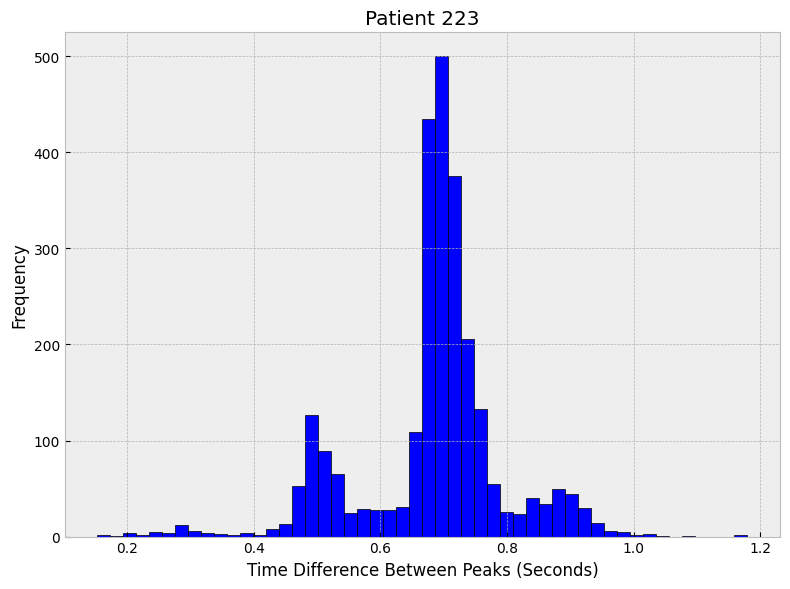

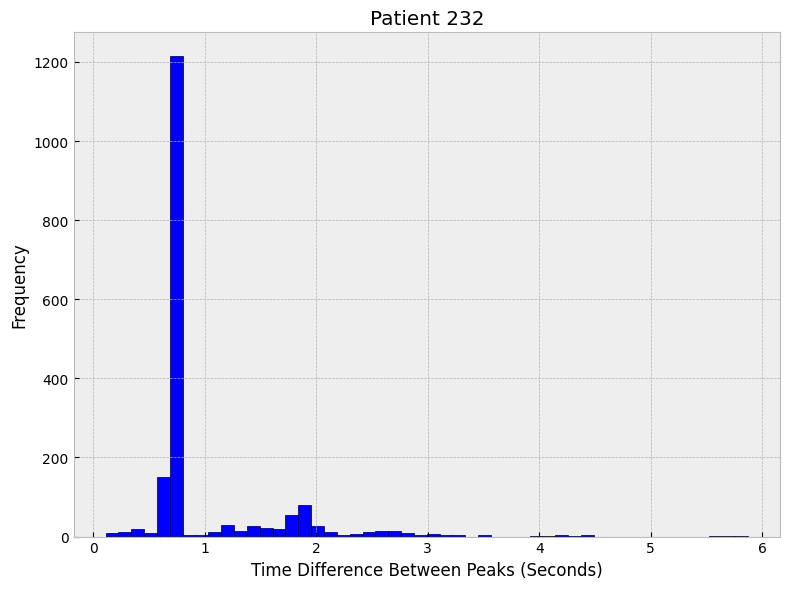

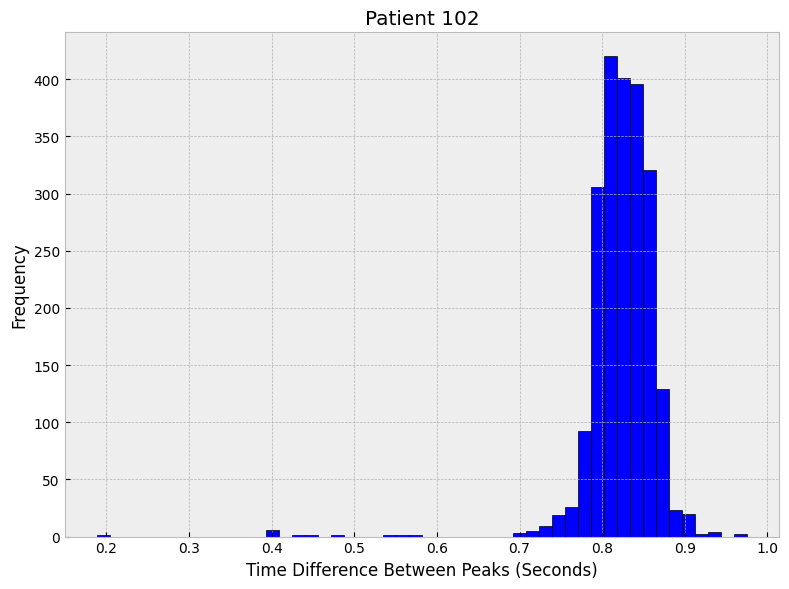

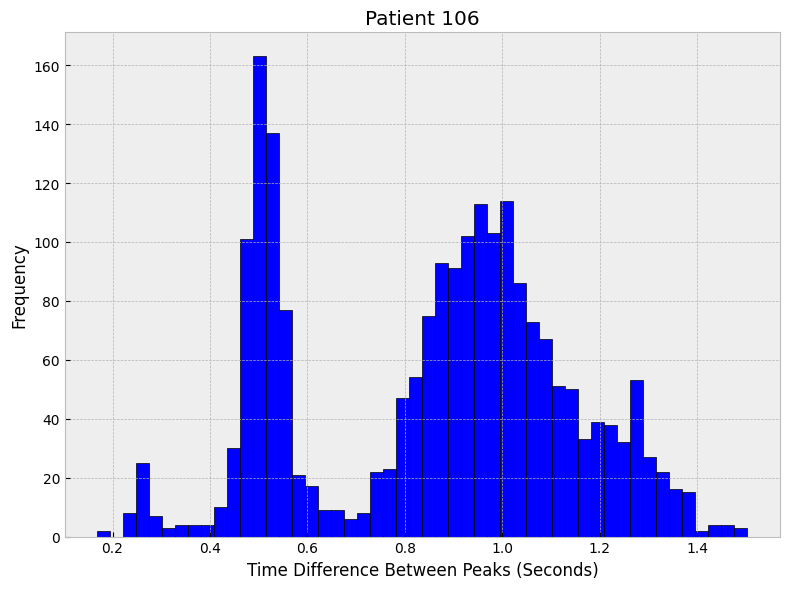

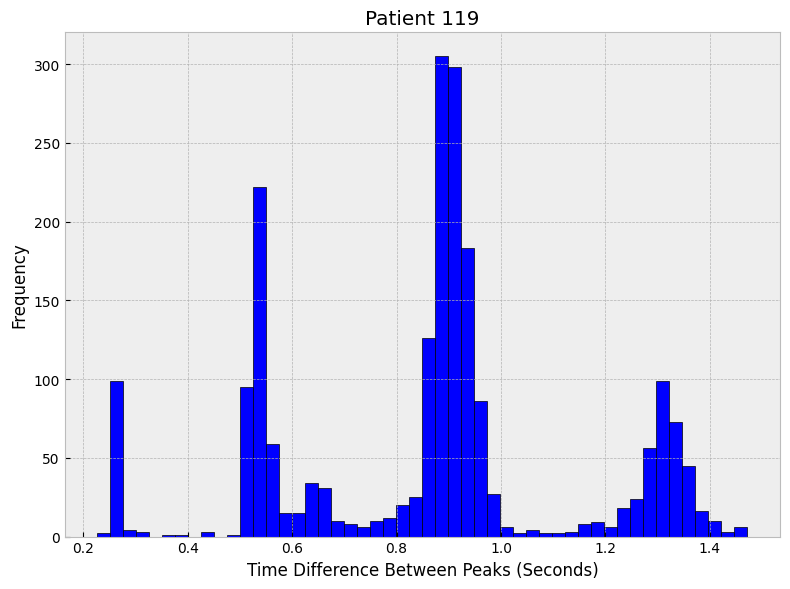

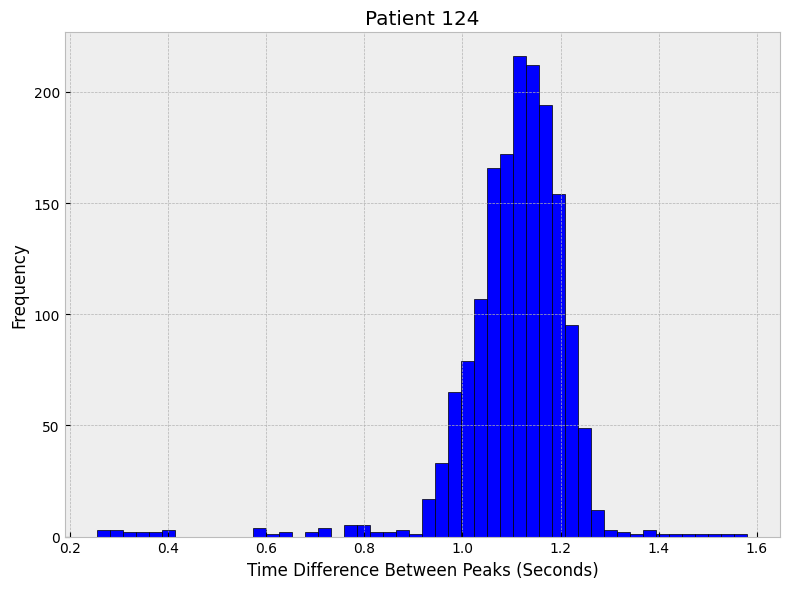

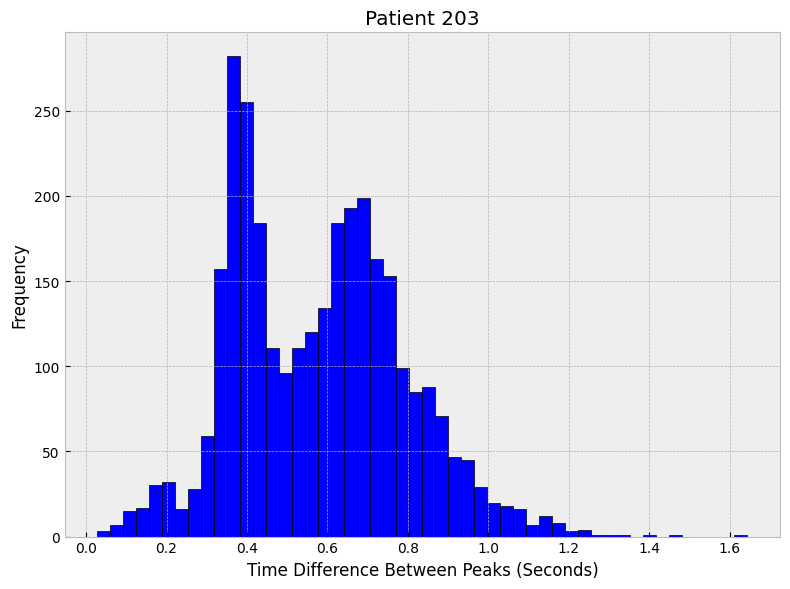

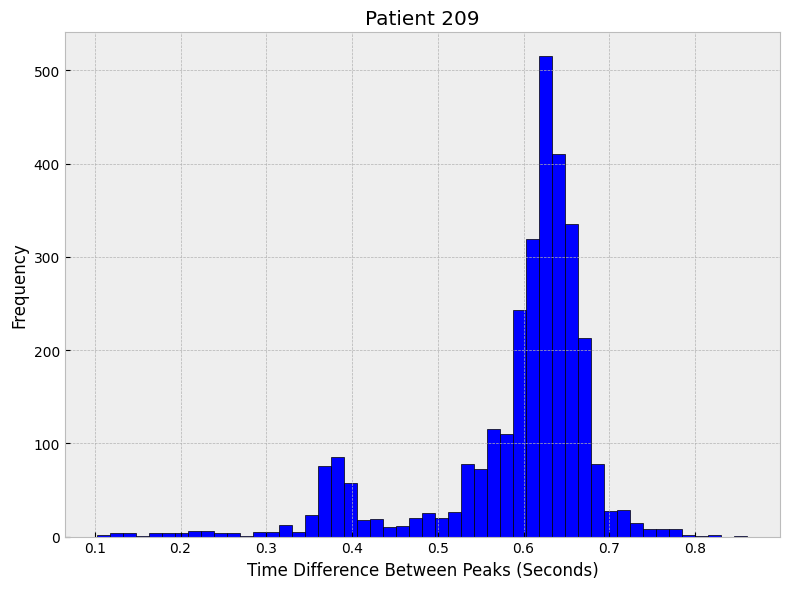

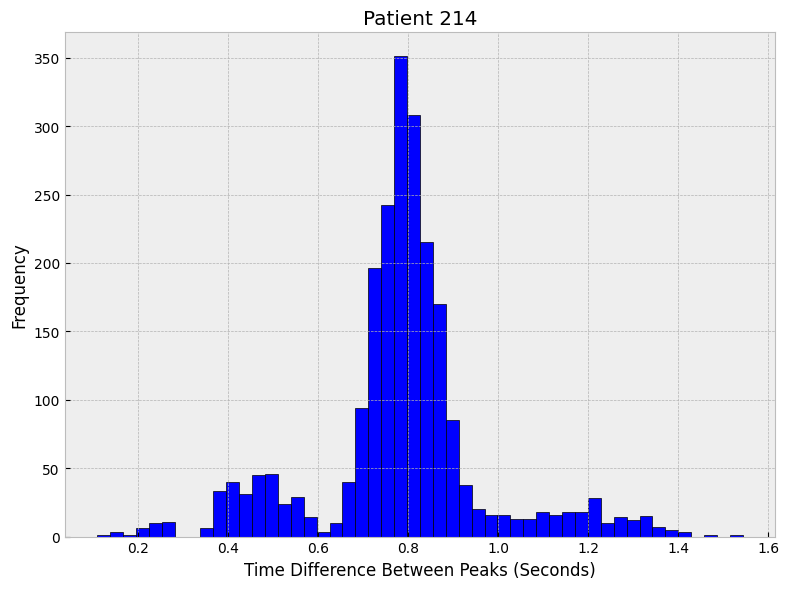

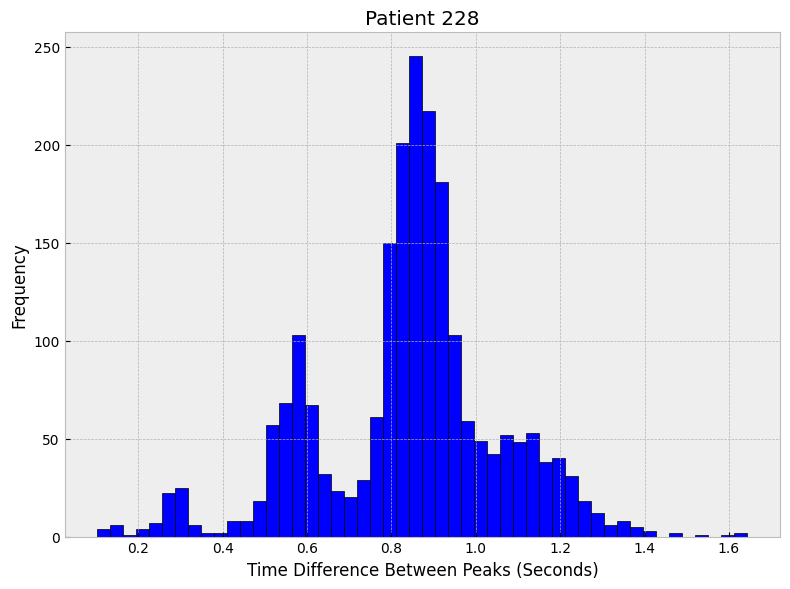

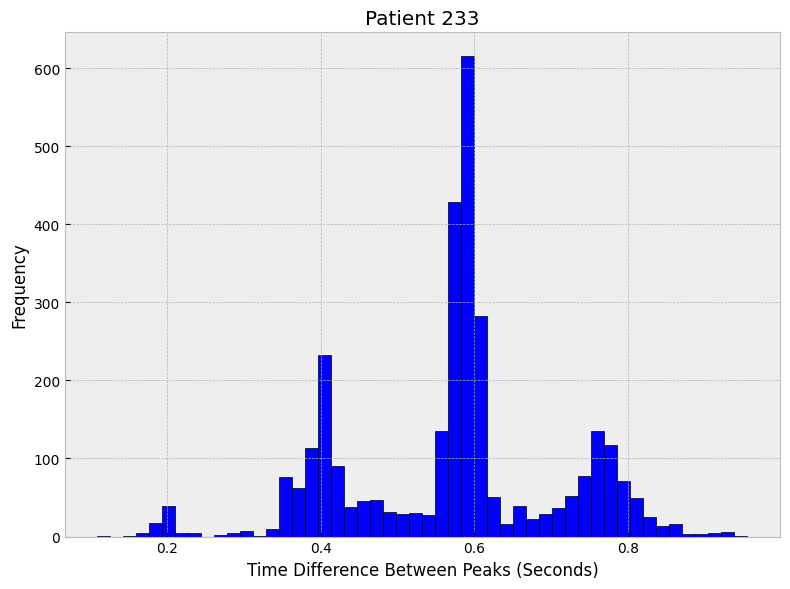

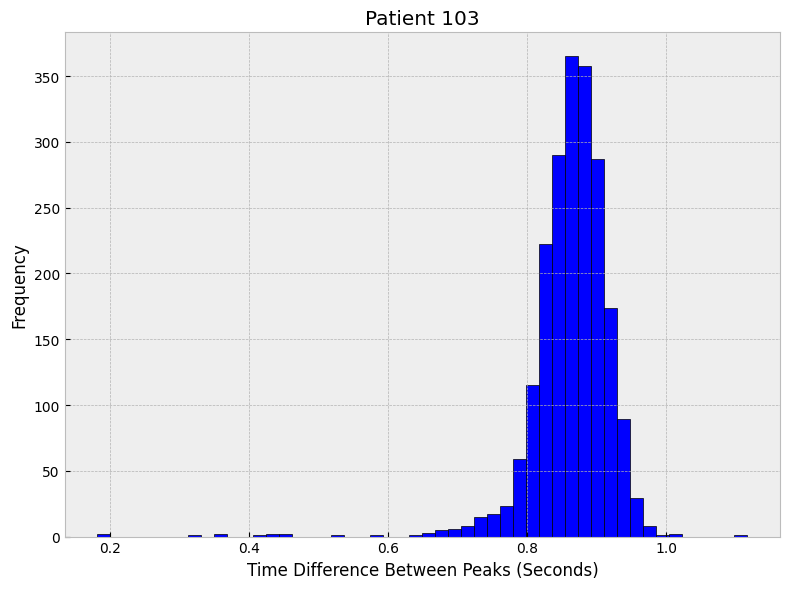

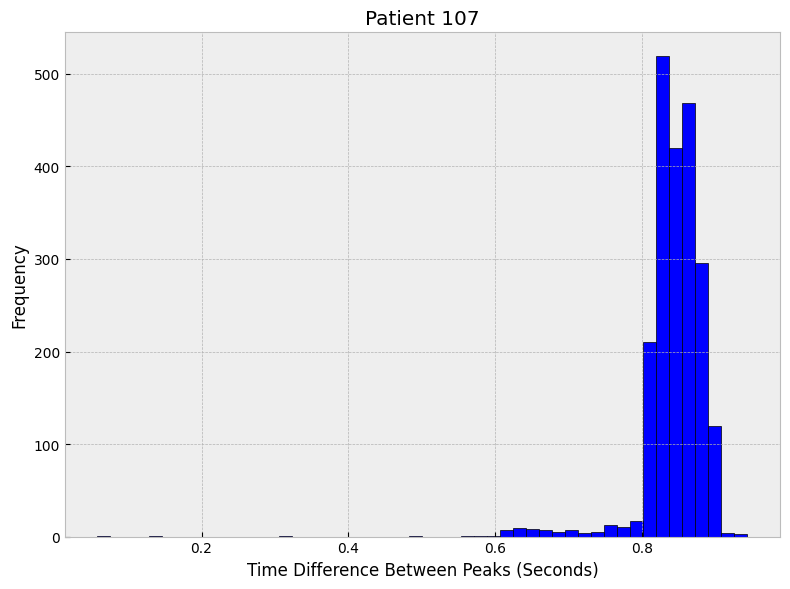

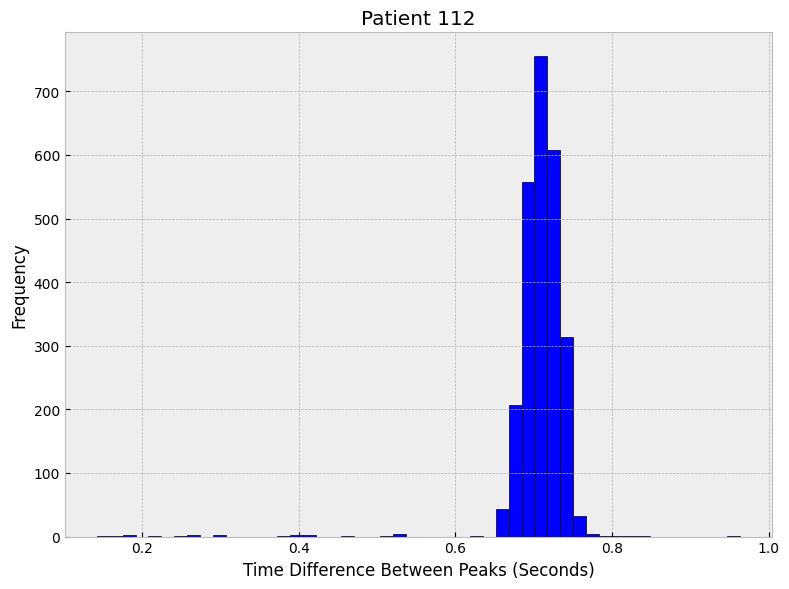

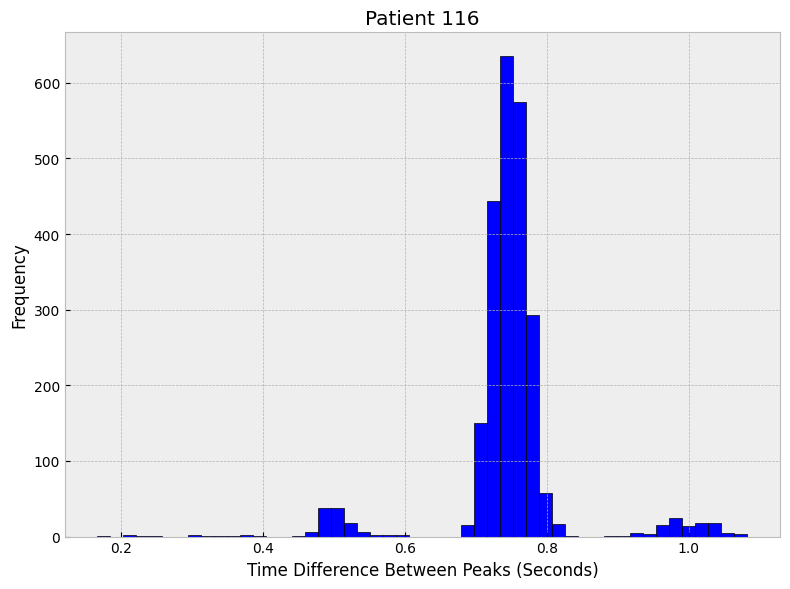

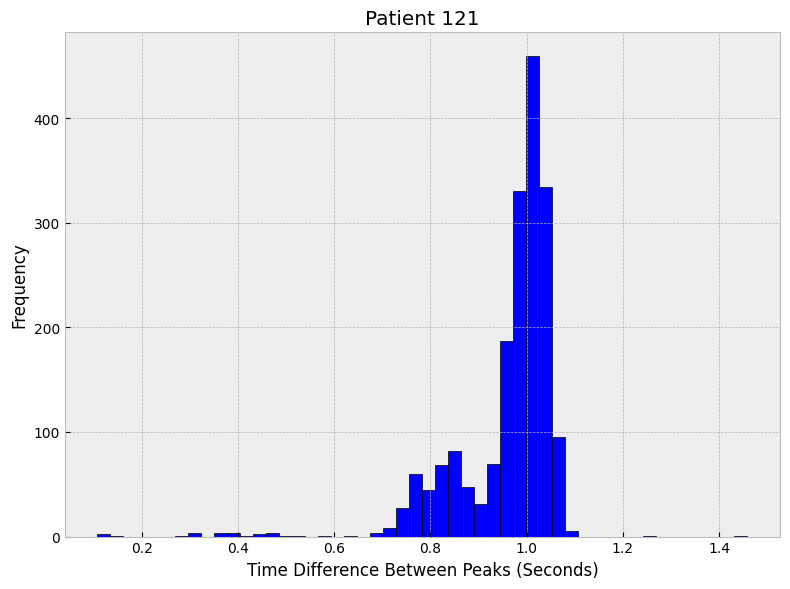

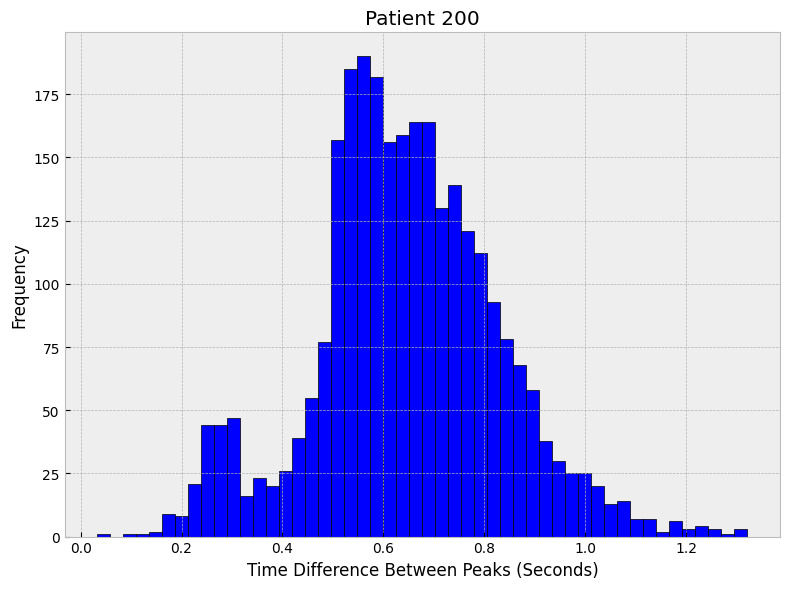

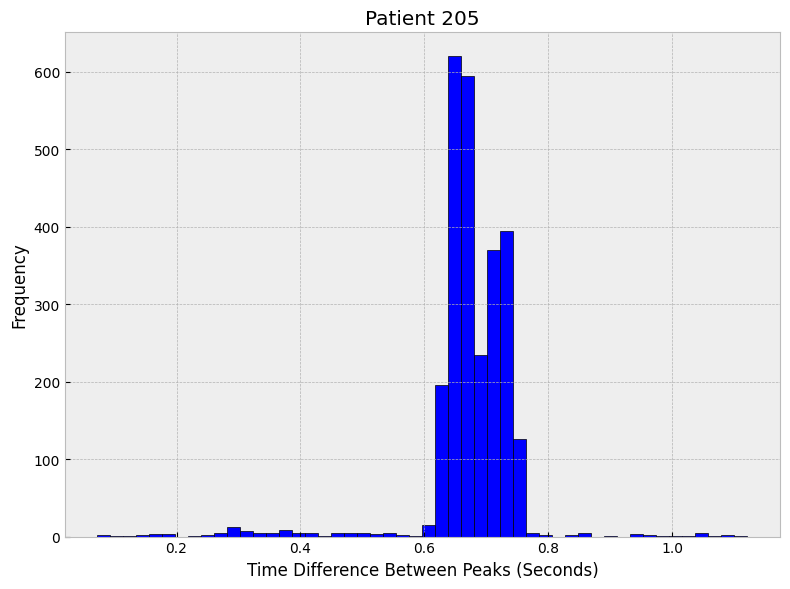

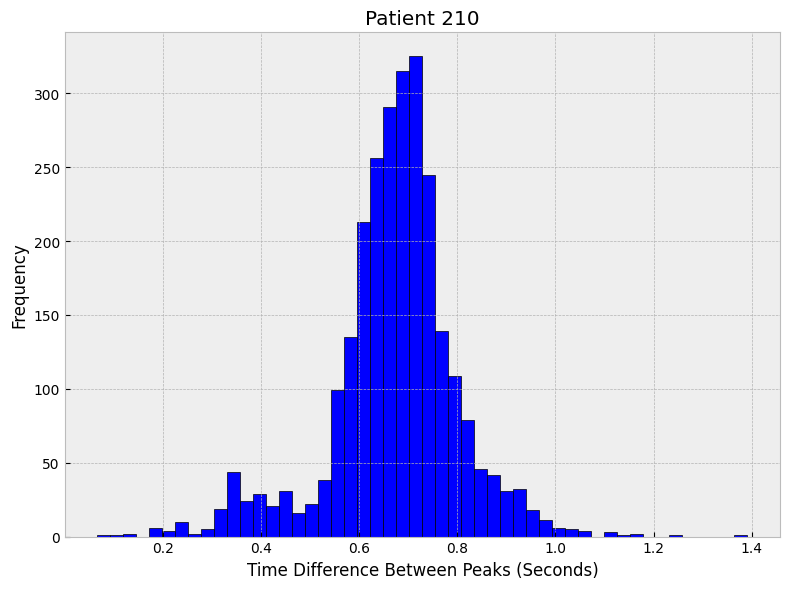

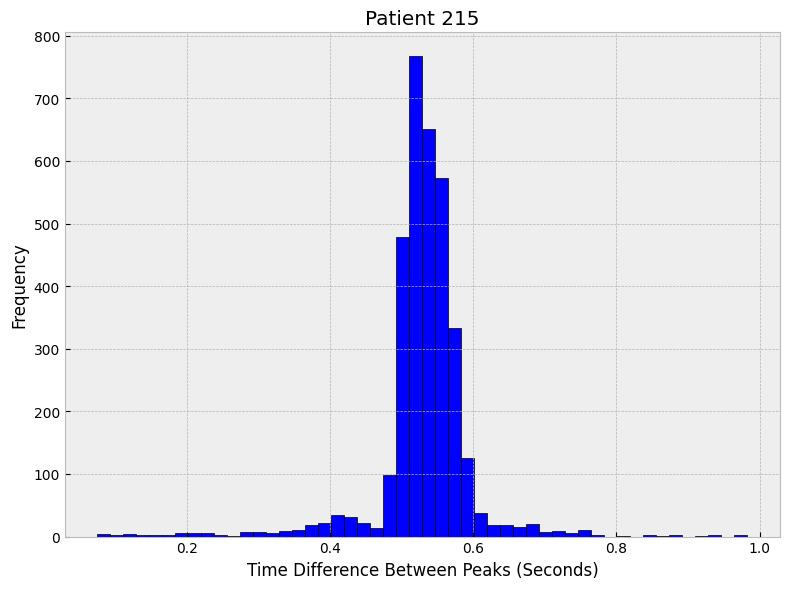

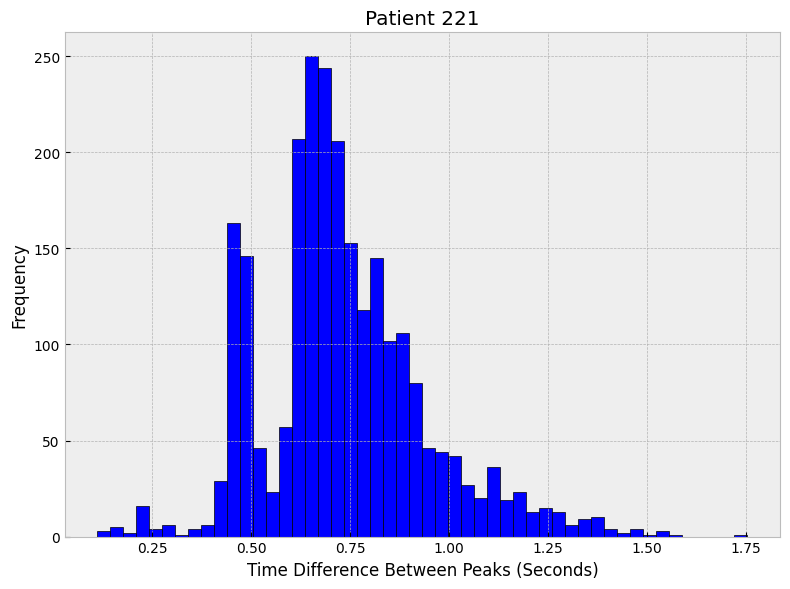

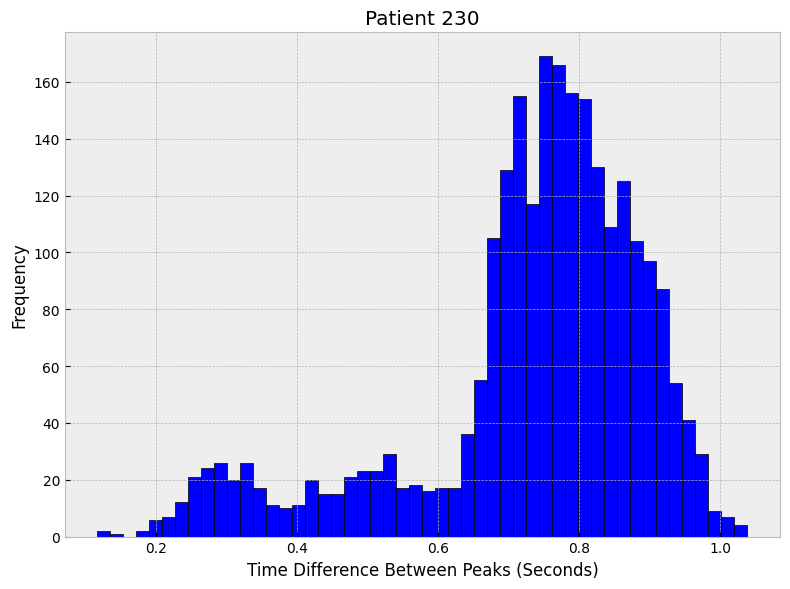

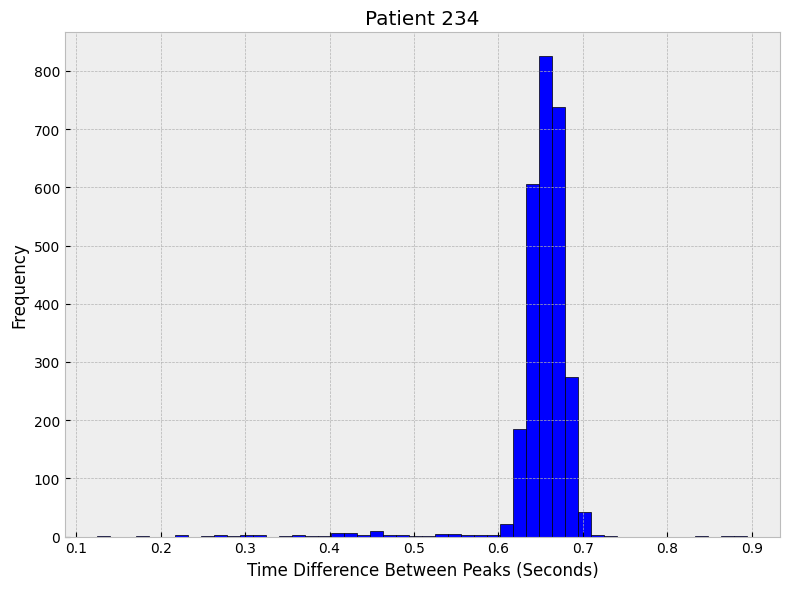

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to convert time string to seconds
def time_to_seconds(time_str):
    min_sec = time_str.split(':')
    minutes = int(min_sec[0])
    seconds = float(min_sec[1])
    return 60 * minutes + seconds

# Define a function to process annotations for a patient and plot a histogram
def process_annotations(patient_id):
    # Read the annotation file
    annotations_file_path = f'./datasets/{patient_id}annotations.txt'
    with open(annotations_file_path, 'r') as file:
        annotations_data = file.readlines()

    # Convert time strings to seconds and calculate differences
    times_in_seconds = [time_to_seconds(line.split()[0]) for line in annotations_data[1:]]  # skip the header
    time_differences = np.diff(times_in_seconds)

    # Plot histogram
    plt.style.use('bmh')
    plt.figure(figsize=(8, 6))
    plt.hist(time_differences, bins=50, color='blue', edgecolor='black')
    plt.title(f'Patient {patient_id}')
    plt.xlabel('Time Difference Between Peaks (Seconds)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Return the time differences for accumulation
    return time_differences

# List of patient IDs
train_patient_ids = ['100', '104', '108', 
                     '117', '201', '207', 
                     '212', '217', '222', 
                     '231', '101', '114', 
                     '123', '208', '213', 
                     '219', '223', '232', 
                     '102', '106', '119', 
                     '124', '203', '209', 
                     '214', '228', '233', 
                     '103', '107', '112', 
                     '116', '121', '200', 
                     '205', '210', '215', 
                     '221', '230', '234']

# Initialize an empty DataFrame to accumulate all time differences
all_time_differences_df = pd.DataFrame()

# Process each patient's annotations and accumulate the results
for patient_id in train_patient_ids:
    patient_time_differences = process_annotations(patient_id)
    all_time_differences_df = pd.concat([all_time_differences_df, pd.DataFrame({patient_id: patient_time_differences})], axis=1)


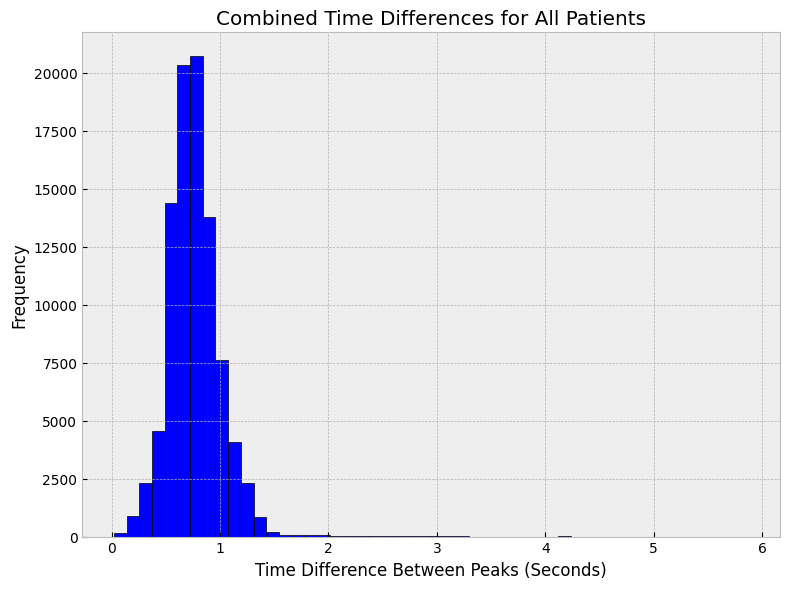

In [15]:
# Flatten the DataFrame into a single series
all_time_differences_series = all_time_differences_df.values.flatten()
all_time_differences_series = all_time_differences_series[~np.isnan(all_time_differences_series)]  # Remove NaN values which are a result of unequal series lengths

# Plot histogram of the flattened series
plt.style.use('bmh')  # Apply the professional style
plt.figure(figsize=(8, 6))
plt.hist(all_time_differences_series, bins=50, color='blue', edgecolor='black')
plt.title('Combined Time Differences for All Patients')
plt.xlabel('Time Difference Between Peaks (Seconds)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()  # Adjust the layout for a professional look
plt.show()


## Autocorrelations

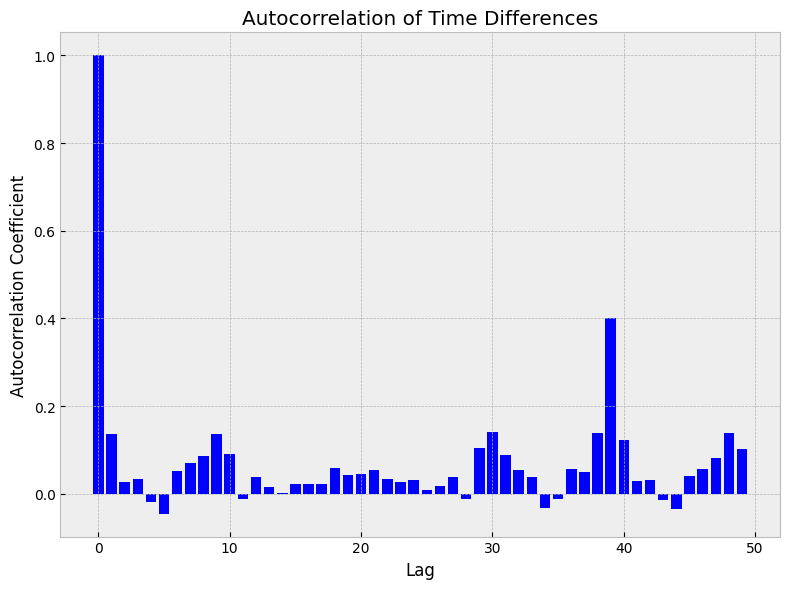

In [16]:
from statsmodels.tsa.stattools import acf

# Compute the autocorrelation using the acf function
autocorrelation_coefficients = acf(all_time_differences_series, fft=True)

# Plot the autocorrelation coefficients
plt.figure(figsize=(8, 6))
lags = range(len(autocorrelation_coefficients))
plt.bar(lags, autocorrelation_coefficients, color='blue')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation Coefficient')
plt.title('Autocorrelation of Time Differences')
plt.grid(True)
plt.tight_layout()
plt.show()


## Spectral Density

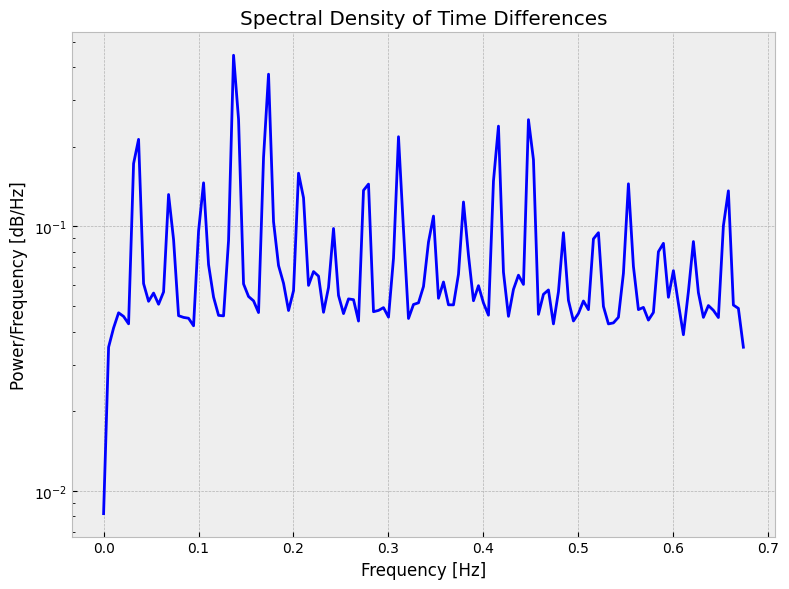

In [18]:
from scipy.signal import welch

# Define the sampling frequency
# Assuming the sampling frequency is the reciprocal of the median time difference between peaks
sampling_frequency = 1 / np.median(all_time_differences_series)

# Compute the spectral density using Welch's method
frequencies, power_spectral_density = welch(all_time_differences_series, fs=sampling_frequency, window='hann', nperseg=256, scaling='density')

# Plot the spectral density
plt.figure(figsize=(8, 6))
plt.semilogy(frequencies, power_spectral_density, color='blue')  # Log scale for y-axis
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power/Frequency [dB/Hz]')
plt.title('Spectral Density of Time Differences')
plt.grid(True)
plt.tight_layout()
plt.show()
